In [1]:
!pip install pycuda

     |████████████████████████████████| 1.7 MB 4.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 75 kB 4.3 MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627558 sha256=670393f0813c3b88170e446a5953668994662ea6aece60bcb97f6c1657617512
  Stored in directory: /root/.cache/pip/wheels/c4/ef/49/dc6a5feb8d980b37c83d465ecab24949a6aa19458522a9e001
  Created wheel for pytools: filename=pytools-2021.2.8-py2.py3-none-any.whl size=60725 sha256=12a167f2c6b72090fdb09beb007ef4b899b601c79f83b663cdecb2e218f68cce
  Stored in directory: /root/.cache/pip/wheels/bd/2d/ef/0127a17bafa44971f11d05d0e38d7947144cf9e33313bf12a7
Successfully built pycuda pytools


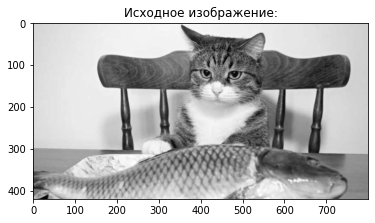

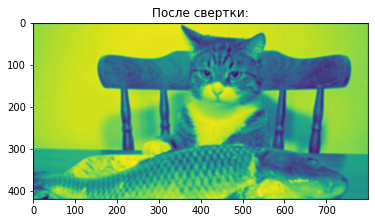

In [65]:
from numba import cuda
import numpy as np
from PIL import Image
import pycuda
pycuda.driver.init()
pycuda.driver.Device(0).retain_primary_context()



@cuda.jit
def convolve(result, mask, image):
    i, j = cuda.grid(2) 
    
    image_rows, image_cols = image.shape
    if (i >= image_rows) or (j >= image_cols): 
        return
    
    delta_rows = mask.shape[0] // 4 
    delta_cols = mask.shape[1] // 4
    
    s = 0
    for k in range(mask.shape[0]):
        for l in range(mask.shape[1]):
            i_k = i - k + delta_rows
            j_l = j - l + delta_cols
            if (i_k >= 0) and (i_k < image_rows) and (j_l >= 0) and (j_l < image_cols):  
                s += mask[k, l] * image[i_k, j_l]
    result[i, j] = s




image = Image.open("image.jpg").convert('L')
image= np.array(image).astype(np.float32)


result = np.empty_like(image)

mask = np.random.rand(5, 5).astype(np.float32) 


blockdim = (16, 16)

griddim = (image.shape[0] // blockdim[0] + 1, image.shape[1] // blockdim[1] + 1)

convolve[griddim, blockdim](result, mask, image)

%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(image, cmap='gray')
plt.title("Исходное изображение:")
plt.figure()
plt.imshow(result)
plt.title("После свертки:")
plt.show()



